In [140]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import time


In [141]:
# Step 2: Load and preprocess the data
fire_df = pd.read_csv("/content/fire.csv")
nonfire_df = pd.read_csv("/content/nonfire.csv")

# Rename non_fire column to fire
nonfire_df = nonfire_df.rename(columns={"non_fire": "fire"})

In [142]:
# Step 2.1: Merge datasets
combined_df = pd.concat([fire_df, nonfire_df], ignore_index=True)

In [143]:
# Step 2.2: Drop missing values
combined_df.dropna(inplace=True)


In [144]:
# Step 2.4: Drop rows with missing values
combined_df.dropna(inplace=True)

In [145]:
# Step 3: Feature selection (excluding date, time, month)
features = ['temperature', 'pressure', 'cloudcover', 'humidity', 'windspeed', 'precipitation']
X = combined_df[features]
y = combined_df['fire']

In [146]:
# Step 4: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [168]:
# Step 5: Train Random Forest Classifier
start_time_rf = time.time()
rf_model.fit(X_train, y_train)
train_time_rf = time.time() - start_time_rf

# Prediction & Latency
start_pred_time_rf = time.time()
rf_preds = rf_model.predict(X_test)
latency_rf = time.time() - start_pred_time_rf

#parallelism:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [171]:
# Step 6: Train Linear Regression Model
start_time_lr = time.time()
lr_model.fit(X_train, y_train)
train_time_lr = time.time() - start_time_lr

start_pred_time_lr = time.time()
lr_preds_raw = lr_model.predict(X_test)
lr_preds = np.clip(np.round(lr_preds_raw), 0, 1).astype(int)
latency_lr = time.time() - start_pred_time_lr



In [170]:
# Step 7: Evaluation Function (normal display)
def evaluate_model(name, y_true, y_pred, y_pred_raw=None, train_time=None, latency=None):
    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("R² Score:", r2_score(y_true, y_pred_raw if y_pred_raw is not None else y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred_raw if y_pred_raw is not None else y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred_raw if y_pred_raw is not None else y_pred)))
    if train_time is not None:
        print("Training Time (s):", train_time)
    if latency is not None:
        print("Prediction Latency (s):", latency)


In [150]:
# Step 8: Evaluate both models
evaluate_model("Random Forest", y_test, rf_preds, train_time=train_time_rf, latency=latency_rf)
evaluate_model("Linear Regression", y_test, lr_preds, lr_preds_raw, train_time=train_time_lr, latency=latency_lr)



Random Forest Evaluation:
Accuracy: 0.999632892804699
Recall: 0.9992695398100804
F1 Score: 0.999634636463281
R² Score: 0.9985315324300066
MAE: 0.0003671071953010279
RMSE: 0.019160041630983685
Training Time (s): 0.9646937847137451
Prediction Latency (s): 0.020255565643310547

Linear Regression Evaluation:
Accuracy: 0.998898678414097
Recall: 0.9985390796201608
F1 Score: 0.9989039093898429
R² Score: 0.8747726317669153
MAE: 0.13787828024802357
RMSE: 0.17693505900386106
Training Time (s): 0.0064678192138671875
Prediction Latency (s): 0.0023937225341796875


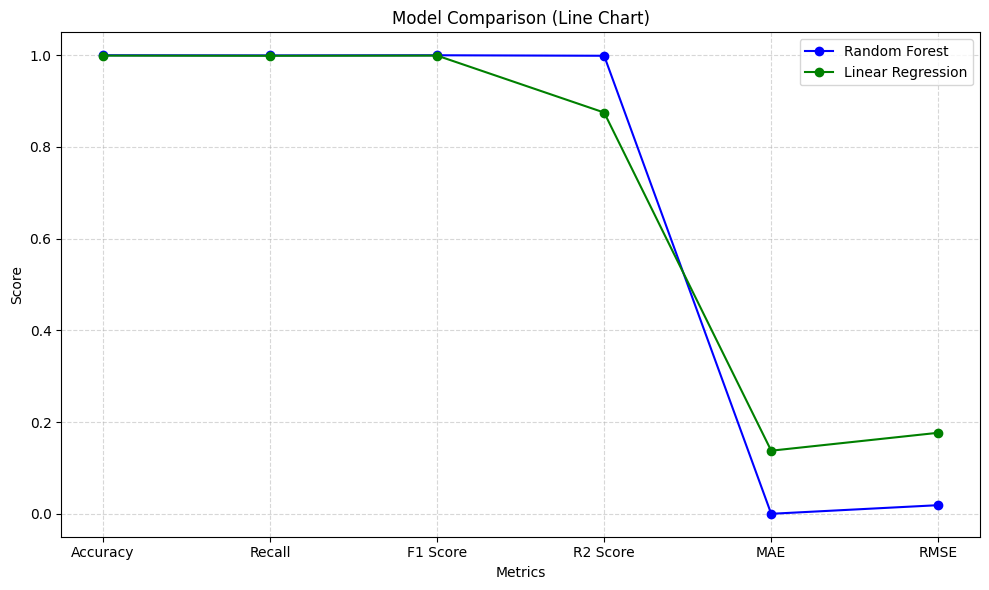

In [151]:
# Step 11: Compare both models using a line chart
import matplotlib.pyplot as plt

# Evaluation metrics
metrics = ["Accuracy", "Recall", "F1 Score", "R2 Score", "MAE", "RMSE"]

# Random Forest values
rf_values = [
    accuracy_score(y_test, rf_preds),
    recall_score(y_test, rf_preds),
    f1_score(y_test, rf_preds),
    r2_score(y_test, rf_preds),
    mean_absolute_error(y_test, rf_preds),
    np.sqrt(mean_squared_error(y_test, rf_preds))
]

# Linear Regression values
lr_values = [
    accuracy_score(y_test, lr_preds),
    recall_score(y_test, lr_preds),
    f1_score(y_test, lr_preds),
    r2_score(y_test, lr_preds_raw),
    mean_absolute_error(y_test, lr_preds_raw),
    np.sqrt(mean_squared_error(y_test, lr_preds_raw))
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(metrics, rf_values, marker='o', label='Random Forest', color='blue')
plt.plot(metrics, lr_values, marker='o', label='Linear Regression', color='green')
plt.title("Model Comparison (Line Chart)")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [152]:
# Step 9: Cross-validation (5-fold)
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
lr_cv_scores = cross_val_score(lr_model, X, y, cv=5, scoring='r2')

print("\nCross-Validation Accuracy (Random Forest):", rf_cv_scores.mean())
print("Cross-Validation R² (Linear Regression):", lr_cv_scores.mean())


Cross-Validation Accuracy (Random Forest): 0.9996328928046989
Cross-Validation R² (Linear Regression): 0.17303936005808543


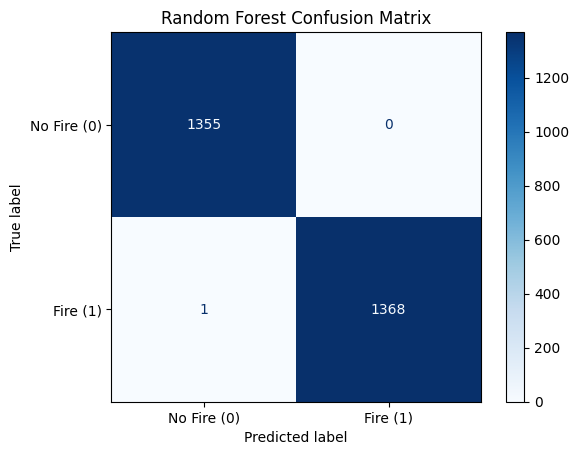

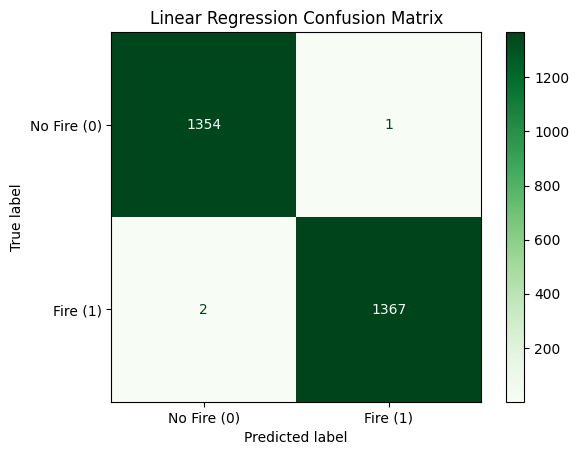

In [153]:
# Fix Linear Regression predictions
lr_preds = np.clip(np.round(lr_preds_raw), 0, 1).astype(int)

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, rf_preds)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Fire (0)", "Fire (1)"])
disp_rf.plot(cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

# Linear Regression confusion matrix
cm_lr = confusion_matrix(y_test, lr_preds)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["No Fire (0)", "Fire (1)"])
disp_lr.plot(cmap="Greens")
plt.title("Linear Regression Confusion Matrix")
plt.show()

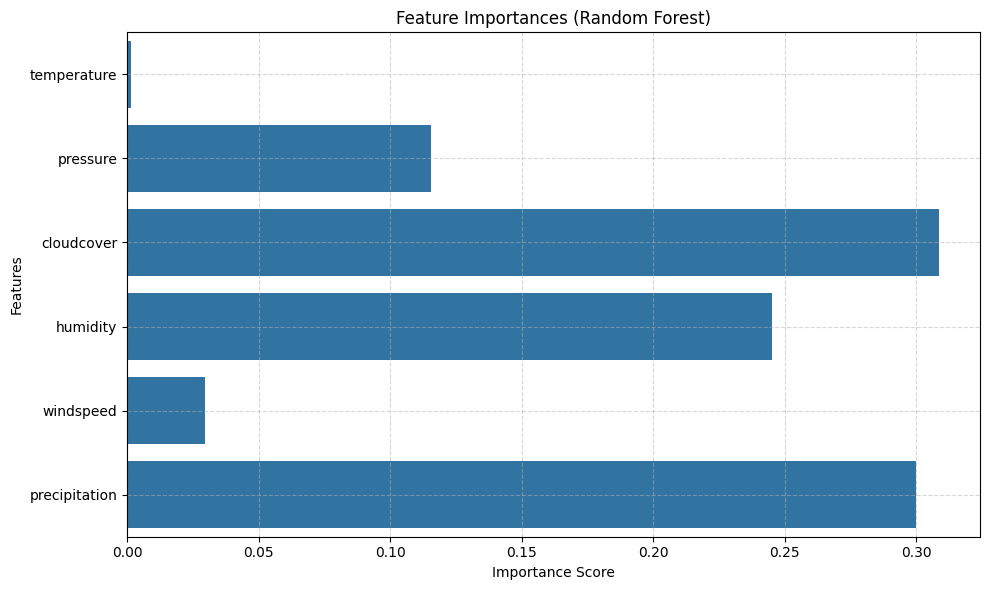

In [154]:
# Step 10: Plot feature importances from Random Forest
feature_importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [155]:
# Your manual input for ambiguous case
manual_input = {
    'temperature': 30.0,       # moderately warm
    'pressure': 1012.0,        # normal pressure
    'cloudcover': 40.0,        # partially cloudy
    'humidity': 45.0,          # not too dry, not too moist
    'windspeed': 7.0,          # moderate wind
    'precipitation': 0.5       # light rain
}

# Convert to DataFrame
input_df = pd.DataFrame([manual_input])

# Assuming rf_model and lr_model are already trained and loaded

# Random Forest prediction probability for fire (class 1)
rf_prob = rf_model.predict_proba(input_df)[0][1]
rf_class = int(rf_prob >= 0.5)

# Linear Regression prediction (continuous)
lr_prob = lr_model.predict(input_df)[0]
# Clip to 0-1 range for probability approximation
lr_prob_clipped = np.clip(lr_prob, 0, 1)
lr_class = int(round(lr_prob_clipped))

# Print results with probabilities and predicted classes
print("\n🔥 Manual Fire Prediction (Difficult Case) 🔥")
print(f"Random Forest Prediction: {rf_class} (Fire Probability: {rf_prob:.2f})")
print(f"Linear Regression Prediction: {lr_class} (Fire Probability Approx.: {lr_prob_clipped:.2f})")


🔥 Manual Fire Prediction (Difficult Case) 🔥
Random Forest Prediction: 0 (Fire Probability: 0.10)
Linear Regression Prediction: 0 (Fire Probability Approx.: 0.31)


In [166]:
def fetch_weather_data(lat, lon):
    url = f"https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "current_weather": True,
        "hourly": "temperature_2m,pressure_msl,cloudcover,relative_humidity_2m,windspeed_10m,precipitation",
        "timezone": "auto"
    }

    response = requests.get(url, params=params)
    data = response.json()

    i = 0  # Use first hour data
    hourly = data["hourly"]
    weather_input = {
        'temperature': hourly["temperature_2m"][i],
        'pressure': hourly["pressure_msl"][i],
        'cloudcover': hourly["cloudcover"][i],
        'humidity': hourly["relative_humidity_2m"][i],
        'windspeed': hourly["windspeed_10m"][i],
        'precipitation': hourly["precipitation"][i],
    }

    return pd.DataFrame([weather_input]), weather_input  # Return both for prediction and display

#  Take location input from user
try:
    lat = float(input("Enter latitude: "))
    lon = float(input("Enter longitude: "))
except ValueError:
    print(" Invalid input. Please enter numeric values for latitude and longitude.")
    exit()

#  Fetch data
real_time_input_df, weather_input_dict = fetch_weather_data(lat, lon)

#  Predict using Random Forest
rf_pred = rf_model.predict(real_time_input_df)[0]
rf_prob = rf_model.predict_proba(real_time_input_df)[0][1]

#  Predict using Linear Regression
lr_raw = lr_model.predict(real_time_input_df)[0]
lr_pred = int(np.clip(round(lr_raw), 0, 1))  # 0 or 1
lr_prob = lr_raw

#  Show Real-Time Weather Data (excluding precipitation)
print("\n Real-Time Weather Data (Open-Meteo):")
print(f"Temperature: {weather_input_dict['temperature']}")
print(f"Pressure: {weather_input_dict['pressure']}")
print(f"Cloudcover: {weather_input_dict['cloudcover']}")
print(f"Humidity: {weather_input_dict['humidity']}")
print(f"Windspeed: {weather_input_dict['windspeed']}")

#  Show Predictions
print("\nReal-Time Fire Risk Prediction ")
print(f"Random Forest Prediction: {rf_pred} (Fire Probability: {round(rf_prob, 2)})")
print(f"Linear Regression Prediction: {lr_pred} (Fire Probability Approx.: {round(lr_prob, 2)})")

Enter latitude: 27.7103
Enter longitude: 85.3222

 Real-Time Weather Data (Open-Meteo):
Temperature: 21.1
Pressure: 1008.2
Cloudcover: 100
Humidity: 86
Windspeed: 6.3

Real-Time Fire Risk Prediction 
Random Forest Prediction: 0 (Fire Probability: 0.03)
Linear Regression Prediction: 0 (Fire Probability Approx.: -0.64)
